## Dependencies

In [1]:
from io import BytesIO
from pdf2image import convert_from_path
from os import listdir, makedirs
from os.path import isfile, join
from tqdm import tqdm
from glob import glob
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pytesseract
import math
import copy
import imutils
from PIL import Image

## Constants

In [31]:
IMAGE_PATH = "../dataset/image"
CHARACTER_PATH = '../dataset/characters'

# Set plot size
plt.rcParams["figure.figsize"] = 15, 15

## Isolation of characters

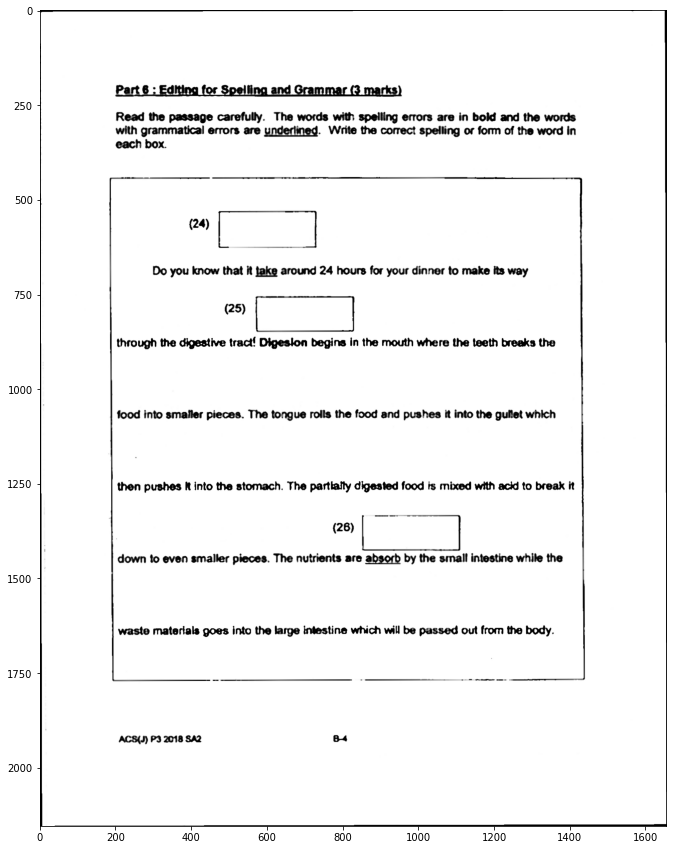

In [112]:
filenames = glob(''.join([IMAGE_PATH, '/*/*.png']))
filenames.sort()
image = cv.imread(filenames[130], cv.IMREAD_GRAYSCALE)
threshold, binarized = cv.threshold(image, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

cannied = cv.Canny(binarized, 50, 200, None, 3)

# For ease of view
distance_resolution = 1
angle_resolution = np.pi / 180
vote_threshold = 180
lines = cv.HoughLines(cannied, distance_resolution, angle_resolution, vote_threshold)
skew_angles = []
if lines is not None:
    for line in lines:
        rho = line[0][0]
        theta = line[0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        dev_from_hrzntal_in_rad = np.pi / 2 - theta 
        dev_from_hrzntal_in_deg = dev_from_hrzntal_in_rad / np.pi * 180
        
        if (abs(dev_from_hrzntal_in_deg) < 10):
            skew_angles.append(dev_from_hrzntal_in_deg)
        
deskew_angle = sum(skew_angles) / len(skew_angles)
deskewed_image = ndimage.rotate(binarized, -deskew_angle)

aperture_size = 5
denoised_image = cv.medianBlur(deskewed_image, aperture_size)

underlay = np.copy(denoised_image)
complete_binarized_image = np.copy(denoised_image)


contours, hier = cv.findContours(cv.bitwise_not(complete_binarized_image), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
rects = []

for idx, c in enumerate(contours):
    x, y, w, h = cv.boundingRect(c)
    rects.append((x, y, w, h))
    # cv.rectangle(underlay, (x, y), (x + w, y + h), 0, 1)  
    

CHARACTER_WIDTH = 20
character_rects = []
PIXEL_THRESHOLD = 30
for rect in rects:
    if rect[2] < CHARACTER_WIDTH:
        character_rects.append(rect)
    else:
        word_image = denoised_image[rect[1]:(rect[1] + rect[3]), rect[0]:(rect[0] + rect[2])]
        projection = np.sum(word_image, 0)
        start = 0
        in_range = False
        for idx, pixel_count in enumerate(projection):
            if pixel_count >= PIXEL_THRESHOLD * 255:
                if not in_range:
                    in_range = True
                    start = idx
            else:
                if in_range:
                    in_range = False
                    character_rects.append((start + rect[0], rect[1], idx - start, rect[3]))
                    start = idx

# for idx, rect in tqdm(enumerate(character_rects)):
#     x, y, w, h = rect
#     cv.rectangle(underlay, (x, y), (x + w, y + h), 0, 1) 
#     word_image = denoised_image[rect[1]:(rect[1] + rect[3]), rect[0]:(rect[0] + rect[2])]
#     word_image = Image.fromarray(word_image)
#     word_image.save(''.join([CHARACTER_PATH, '/', f'{idx}.png']), 'PNG')

plt.imshow(cv.cvtColor(underlay, cv.COLOR_BGR2RGB))



In [132]:
idx = 91

501


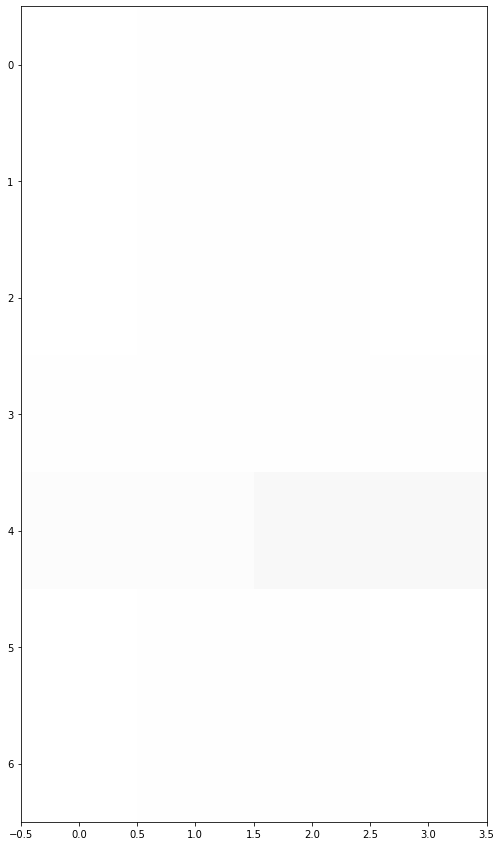

In [133]:
print(len(rects))
word_image = denoised_image[rects[idx][1]:(rects[idx][1] + rects[idx][3]), rects[idx][0]:(rects[idx][0] + rects[idx][2])]
underlay = np.copy(word_image)

kernel = np.ones((3,3),np.uint8)
word_image = cv.dilate(word_image, kernel, iterations = 1)

contours, hier = cv.findContours(cv.bitwise_not(word_image), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
temp = []
for c in contours:
    x, y, w, h = cv.boundingRect(c)
    temp.append((x, y, w, h))
    cv.rectangle(underlay, (x, y), (x + w, y + h), 255, 1)
    
    
plt.imshow(cv.cvtColor(underlay, cv.COLOR_BGR2RGB))

word_image = cv.cvtColor(underlay, cv.COLOR_BGR2RGB)
word_image = Image.fromarray(word_image)
word_image.save(''.join([CHARACTER_PATH, '/', f'{idx}.png']), 'PNG')


501
[6624 6516 5055 4050 3569 3346 3592 3813 3824 4048 3590 3850 4052 4076
 3864 3374 3587 3346 3346 3092 3131 4128 5074 5486 5137 2070 1495 1043
 1584 2198 4867 5412 5889 5858 5636 5244 3347 3124 3617 4420 4456 4417
 3486 2440 1555 2308 3665 6391 6422 6423 4079 3565 3097 3639 4171 4436
 4883 4874 4394 4358 4365 4389 4858 4372 3753 1802 1279 1033 1334 1920
 4817 5371 5673 5640 5577 4986 2853 2831 3094 3700 6110 6624]
2
25
36
50
75
[(2, 0, 21, 26), (25, 0, 6, 26), (36, 0, 11, 26), (50, 0, 21, 26), (75, 0, 5, 26)]


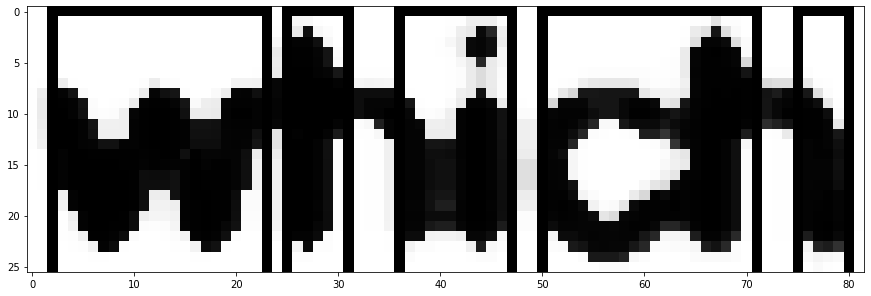

In [131]:
print(len(rects))
word_image = denoised_image[rects[idx][1]:(rects[idx][1] + rects[idx][3]), rects[idx][0]:(rects[idx][0] + rects[idx][2])]
underlay = np.copy(word_image)

character_rects = []
PIXEL_THRESHOLD = 20
projection = np.sum(word_image, 0)
print(projection)
start = 0
in_range = False
for index, pixel_count in enumerate(projection):
    if pixel_count < PIXEL_THRESHOLD * 255:
        if not in_range:
            print(index)
            in_range = True
            start = index
    else:
        if in_range:
            in_range = False
            character_rects.append((start, 0, index - start, rects[idx][3]))
            start = index

for idx, (x, y, w, h) in enumerate(character_rects):
    cv.rectangle(underlay, (x, y), (x + w, y + h), 0, 1) 

print(character_rects)
plt.imshow(cv.cvtColor(underlay, cv.COLOR_BGR2RGB))

word_image = cv.cvtColor(underlay, cv.COLOR_BGR2RGB)
word_image = Image.fromarray(word_image)
word_image.save(''.join([CHARACTER_PATH, '/', f'{idx}.png']), 'PNG')
